### Spectrometer Control Notebook

Make sure you followed the instructions in the Camera Control Notebook and were able to record a spectrum with your Lego Spectrometer 📈.

In [1]:
import io
import csv
import ipywidgets as widgets
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

from picamera import PiCamera
from PIL import Image, ImageDraw
from time import sleep, strftime
from IPython.display import clear_output, HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Helpful routines

In this section we define various helper routines we use for spectrometer control. We will go over them, but you can think of them as 'fancy' commands you can use later in this notebook. Make sure you execute all the cells.

### Routine `takePicture()`

To make things easy, we define a routine to take an image with the Raspberry Pi Camera. The camera you have has a maximum resolution of 2592 x 1944 pixels. The options are set for the spectrometer setup. Note we rotate the image 270 degrees.

In [2]:
def takePicture(shutter):
    
    camera = PiCamera()
    stream = io.BytesIO()
    try:
        # Full camera resolution is 2592 x 1944 - we run at 1/4 resolution 
        camera.resolution = (648, 486)        
        camera.framerate= 5
        camera.rotation = 270
        camera.iso = 800
        camera.shutter_speed = shutter
        camera.awb_mode = 'off'
        camera.awb_gains = (1, 1)

        print("Allowing camera to warmup")
        sleep(1)
        print("Capturing image")

        camera.capture(stream, format='jpeg')
        stream.seek(0)
        raw = Image.open(stream)
    finally:
        camera.close()
    return raw

### Routine `cropImage()`

This routine shows the image with coordinates and a grid and shows the cropping area. Optionally it can rotate the image so the spectrum lines are vertical.

In [3]:
def cropImage(img,crop,angle):
    
    if(angle != 0.0):
        img = img.rotate(angle)
        
    temp = img.copy();
    draw = ImageDraw.Draw(temp)
    draw.rectangle(crop, outline=(0, 255, 0), width=2)
    
    # Show the drop area
    ax = plt.gca()
    ax.grid(color='yellow', linestyle='dotted', linewidth=1)
    plt.imshow(temp)
    
    return img.crop(crop)

### Routine `adjustBrightness()`

This is an optional step. If checks for the larges color value and scales it up to the maximum allowed value of 255. This is especially good for spectra with weak signals. 

In [4]:
def adjustBrightness(image):
    
    pixels = np.asarray(image)
    maxcol = [pixels[:,:,0].max(),pixels[:,:,1].max(),pixels[:,:,2].max()]
    factor = int(255 / max(maxcol))
    print ('Brightness factor : ', factor)
    
    adjusted = factor*pixels
    return Image.fromarray(np.uint8(adjusted)) # Convery if back to an image

### Routine `getSpectrum()`

To get from the cropped image to the spectrum (line plot), we need to average values along columns (y) and the colors (r,g,b), so our spectrum is a list of values with the length of the width of the image. We then use the known wavelengths of two color lines (e.g from the CFL bulb) to convert the pixel number along x to a wavelength.

In [5]:
def getSpectrum(processed, wavelength1, wavelength2, pixel1, pixel2):
    
    spectrum = np.asarray(processed)            # Convery to Numpy array for calculations
    spectrum = np.average(spectrum, axis=(0,2)) # Average columns and color values
    spectrum = spectrum-(0.9*min(spectrum))     # Subtract baseline
    
    if (wavelength1 > wavelength2):
        print ('ERROR: First wavelength needs to be smaller than second one given!')
        
    wavelength = np.arange(float(len(spectrum)))
    factor = (wavelength2 - wavelength1) / (pixel2 - pixel1)
    wavelength = wavelength1 + (wavelength - pixel1) * factor
    
    return wavelength, spectrum

### Routine `saveCSV()`

Saving our spectrum to a CSV file.

In [6]:
def saveCSV(fname, spectrum, wavelength):
    with open(fname, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Wavelength","Intensity"])

        for l,i in zip(wavelength, spectrum):
            writer.writerow([l,i])

    print ("Data written to file "+fname)

### Routine `createHTML()`

Creates a HTML page with results using the file `template.html`.

In [7]:
def createHTML(lightSource, scientistName, transmissionSample, experimentNotes, measurementTaken, shutter):
    
    hfile="docs/experiment-"+measurementTaken+".html"
    
    with open("docs/template.html", "rt") as fin:
        with open(hfile, "wt") as fout:
            for line in fin:
                line = line.replace('%%lightSource%%', str(lightSource))
                line = line.replace('%%measurementTaken%%', str(measurementTaken))
                line = line.replace('%%scientistName%%', str(scientistName))
                line = line.replace('%%transmissionSample%%', str(transmissionSample))
                line = line.replace('%%shutter%%', str(shutter))
                line = line.replace('%%experimentNotes%%', str(experimentNotes))

                fout.write(line)

    print("Created "+hfile)
    
    entry='''<tr><td><img src="images/processed-{0}.jpg" align="right">
            Scientist: <strong>{1}</strong><br>
            Light source: <strong>{2}</strong><br>
            Transmission sample: <strong>{3}</strong><br>
            Date and time: <strong>{0}</strong><br>
            <a href="experiment-{0}.html" target="_blank"><button>Details</button></a></td></tr>
        <!--%%entry%%-->'''
    
    out=""
    with open("docs/index.html", "rt") as fin:
        for line in fin:
            out += line.replace('<!--%%entry%%-->', 
                   entry.format(measurementTaken, scientistName, lightSource, transmissionSample))
            
    with open("docs/index.html", "wt") as fout:
        fout.write(out)
        
    print ("Updated index.")

# Spectrometer Control
### Step 1 - Take image

In this first cell we set all the experiment variables and descriptions and take the image. The shutter is given in *microseconds*, so for one second you would enter 1000000. The longest exposure is 6 seconds or 6000000. The other variables are explained in the comments. **Make sure to  update all the fields as they are used when making the log page.**

Allowing camera to warmup
Capturing image


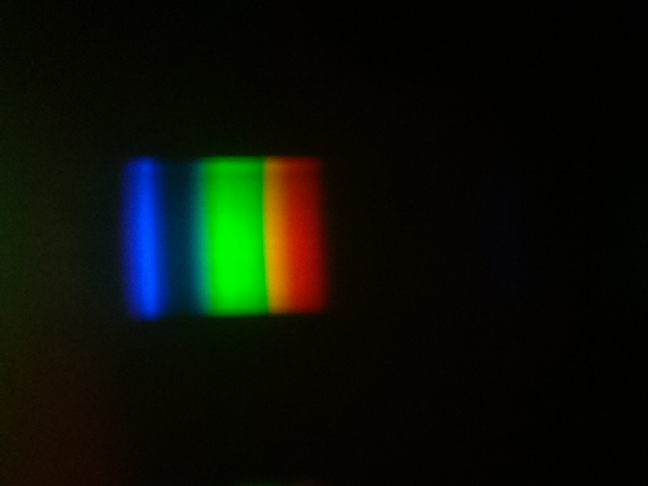

In [9]:
# Change these to match your experiment

lightSource        = "My Dad's Phone Light"
scientistName      = "Thuviksa Mathialakan"
transmissionSample = "None"
experimentNotes    = '''
This is a test measurement during initial code development.
Tracing paper used between light and entrance slit. 
Small slit used.
'''
measurementTaken = strftime("%Y%m%d-%H%M%S") 

# Exposure time
shutter = 50000

# Take the image, save and display
raw = takePicture(shutter)
raw 

### Step 2 - Cropping the image

Next we need to crop the image to just include the area showing the spectrum. We will first add a rectange to the image to show the current area. The crop region is given by the top left and bottom right points. **Keep ajusting the crop area and rerun this cell until the area only includes the 'good' part of the spectrum.**

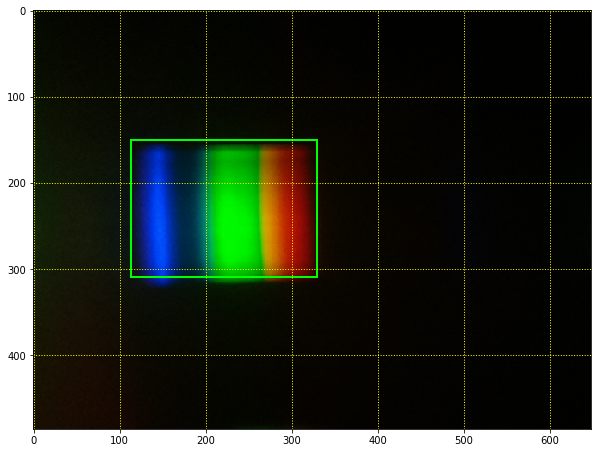

In [31]:
angle=0.0
crop=[113,150,330,310]

processed = cropImage(raw,crop,angle)

And here is the cropped images stored in the `processed` variable.

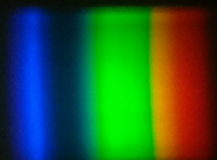

In [32]:
processed

We can adjust the brightness of the picture to scale the highest color value to its maximum of 255.

Brightness factor :  1


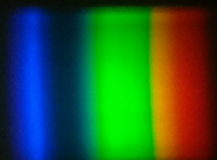

In [33]:
processed = adjustBrightness(processed)
processed

### Step 3 - Extracting spectum and converting to wavelength

Next we need to extract a 1D spectrum by averaging avlues along columns of the image. We also need to convert the pixel number on the x-axis to wavelenth. 

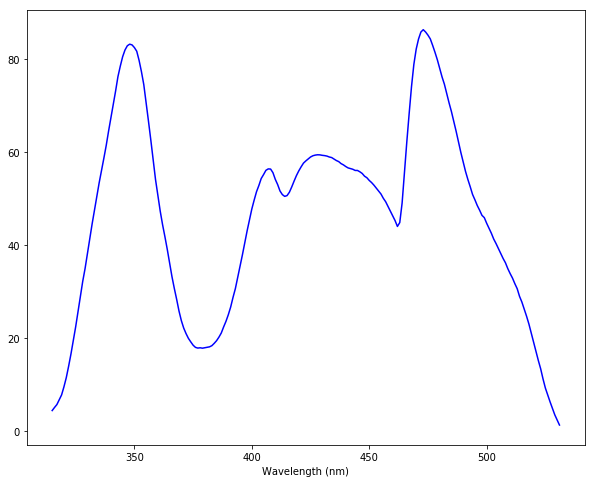

In [34]:
# pixel number of the green and orange line in the CFL spectrum 
pixelGreen = 230
pixelOrange = 300

# Wavelength in nm for those lines (e.g. from reference spectrum)
wavelengthGreen = 545
wavelengthOrange = 615

wavelength, spectrum = getSpectrum(processed, wavelengthGreen, wavelengthOrange, pixelGreen, pixelOrange)

plt.xlabel('Wavelength (nm)')
plt.plot(wavelength, spectrum, color='blue')
plt.savefig("docs/images/spectrum-"+measurementTaken+".jpg")

### Step 4 - Saving everything

We will save the raw image, the processed image and the spectrum plot.

In [35]:
raw.save("docs/images/raw-"+measurementTaken+".jpg")
processed.save("docs/images/processed-"+measurementTaken+".jpg")
saveCSV("docs/data/spectrum-"+measurementTaken+".csv", spectrum, wavelength)

Data written to file docs/data/spectrum-20211113-171803.csv


Last we save the results on a webpage (log book). You can style the page by editing `template.html`. Make sure not to change the `%%xxx%%` placeholders.

In [36]:
createHTML(lightSource, scientistName, transmissionSample, experimentNotes, measurementTaken, shutter)

Created docs/experiment-20211113-171803.html
Updated index.


If you want to see the log book webpages, you can either commit and push all files to GitHub. Alternatively you can open a terminal window and start a webserver on your Raspberry Pi using these commands

```
        cd LegoSpectrometer/docs
        python3 -m http.server
```

The directory might be different for you. Then in a new tab in your webbrowser navigate to `orcspi.local:8000` or use your IP address if `orcspi.local` does not work.

## You are a true scientist now 👩‍🔬👩🏾‍🔬